# Pedestrian Analysis
# on Linked Data: Crash (MV104) + Hospital (SPARCS)

In [1]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np
import itertools
from patsy import dmatrices
import statsmodels.api as sm

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import databuild as db
import analysis as an


/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Pedestrian/Bicyclist Data
The MV104 crash database is compiled by DMV into three tables: 
* crash table, 
* person table, and 
* vehicle table. 

The databuild.py script reads in the tables and organizes them into a person level table for pedestrians or bicyclists involved in 1-vehicle crashes.

The script also reads in the linked hospital-crash data from DOHMH and adds the hospital info (e.g. the person's b-ISS score) onto the ped file.

The resulting dataframe (ped) is what the rest of the analyis in this notebook uses. It only includes injured people who were able to be linked to hopital data by DOHMH.

In [2]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()

# reorganize into pedestrian/bicyclist 1-veh crashes
ped = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()

# included biss data from linked onto ped (dropping anything not in linked)
ped = db.mergeBiss(ped,linked)

#format and categorize variables
ped = db.formatVars(ped)

print 'linked ped',ped.shape

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


full crash table (522108, 26)
full person table (1502797, 22)
full vehicle table (1092922, 20)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,9,20,25,35,48,54,58,63,65,85,89,102,126,128,129,138) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pedestrians/bicyclists (police reported) (single vehicle) (95292, 80)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
linked ped (17624, 106)


## Defining Severe

Patients with a derived Injury Severity Score (b-ISS) of 9 or greater we defined as a severe case. While generally the bar is set at ISS 16 or greater (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3217501/ ), we chose a lower threshold to take into account injuries such as a broken leg (ISS = 9) which may be low on a threat to life scale but can have significant impact on a person’s ability to work and get around in the near term. 

We could have chosen to do an analysis without assigning a threshold (for instance using an AUC measure), however most implementations would necessitate defining a threshold at some point.


## Section A. Univariate analysis - Severity Ratio

We use the Severity Ratio to understand which crash attributes are associated with a severe outcome. The Severity Ratio (SR) is defined as the probability of a severe injury outcome given an attribute was present divided by the probability of a severe injury outcome (irrespective of whether the attribute is present or not). (Note: this is slightly different from the usual definition of Risk Ratio where the denominator is probability of a severe outcome given the attribute is NOT present).

$$ SR = \frac{P( severe \space | \space attribute )}{P(severe)} $$

If SR is much greater than 1 then having the attribute present indicates those types of crashes have a higher likelihood of a severe outcome. If SR is close to 1 then that attribute is not anymore indiciative of severity than a random crash.

The denominator of SR is calculated in the next cell (around .10 for pedestrians/bicyclists)

In [3]:
# baseline severity -- this is the denominator of the SR
pedNumSev = ped[ped.biss_severity_9=='severe'].shape[0]
pedNum = ped.shape[0]
pedPctSev = pedNumSev/float(pedNum)*100
print 'percent of ped with severe outcomes',pedPctSev

percent of ped with severe outcomes 9.69133000454


In [4]:
def sratio(data):
    ''' 
    returns a dataframe where: 
        rows are attributes (factors) - these are columns from input data, 
            prefixed by f_  
        columns are SevereCount - number of severe cases for that attribute(factor)
                    AllCount - total number of cases, severe or not, for that attribute
                    SeverePct - percent of of cases which are severe for that attribute
                    SeverityRatio - SeverePct divided by total percent severe 
                                    irrespective of attribute.
    input data: each row is a person injured in a crash, columns are 
        crash attributes or factors prefixed by f_
    '''
    factors = data.filter(like='f_').columns
    factors = factors.drop(['f_AgeYear','f_DriverAgeYear']) #redundant
    ctlist = []
    keys = []
    
    # figuring out the risk conditional on a factor being present P(severe|factor)
    for factor in factors:
        df = data[data.biss_severity_9=='severe'].groupby(factor).count()[['CI_ID']]\
        .rename(columns={'CI_ID':'SevereCount'}) 
        df['AllCount']= ped.groupby(factor).count()[['CI_ID']]
        df['SeverePct'] = df.SevereCount/df.AllCount
        
        ctlist.append(df)
        keys.append(factor)    
    factordf = pd.concat(ctlist,keys=keys).sort_values('SeverePct')
    
    # baseline risk is not conditional on any factors P(severe)
    baseRisk = data[data.biss_severity_9=='severe'].shape[0]/float(data.shape[0])
    factordf['SeverityRatio'] = factordf['SeverePct']/baseRisk

    # combine index into one column
    factordf.index = factordf.index.map('{0[0]}:{0[1]}'.format)
    # renaming 
    factordf.index = factordf.index.str.replace('f_','')
    factordf.index = factordf.index.str.replace(':',' : ')
    
    return factordf

def bootstrapSR(data,N=10):
    '''returns a dataframe where each column is a random sample from 
    the input data. Total of N samples (columns)
    this sampled data is used to create confidence intervals around the 
    severity ratio metric
    '''
    sample=pd.DataFrame()
    for i in range(N):
        sample[i] = sratio(data.sample(frac=1,replace=True))['SeverityRatio']
    return sample

def plotSR(value, sample, minSR = 1.3,colors='lightblue'):
    ''' returns a plot of the values, with error bars set by the sample dataframe
    only showing attributes where the severity ratio is greater than maxSR
    '''
    errmax = sample.quantile(.95, axis =  1) - value['SeverityRatio']
    errmin = value['SeverityRatio'] - sample.quantile(.05, axis =  1)
    df = value[value.SeverityRatio>minSR] #only plot attributes with large ratios
    error = [[errmin[df.index],errmax[df.index]]]

    df.SeverityRatio.T.plot(kind='barh',xerr=error,color=colors,figsize=(8,8))
    plt.axvline(x=1,color='grey')
    plt.xlabel('severity ratio',fontsize=20)
    plt.title('Top Predictors of Severe Injury \n for pedestrians or bicyclists',fontsize=22)
    
def renameLabels(df):
    '''rename labels in the output of sratio() and bootstrapSR()
    this is to make the graph have more readable labels.
    it's ridiculously difficult to change the labels in matplotlib, 
    so I'm changing them in the source dataframes instead. 
    ''' 
    index = df.index
    shortIndex = list(set([i.split(' :')[0] for i in index]))

    changeIndex = {
        'Sex':'Sex',
        'RoadSurface':'Road Surface',
        'OtherVehTypeVIN':'Vehicle Type',
        'Eject':'Eject',
        'Age70':'Age70',
        'TrafficControl':'Traffic Control',
        'InjuryStatus': 'Injury Status',
        'DriverSex':'Driver Sex',
        'PedLoc': 'Pedestrian Location',
        'InjuryType':'Injury Type',
        'InjuryLoc': 'Injury Location',
        'PedAction': 'Pedestrian Action',
        'Weather':'Weather',
        'Role':'Role',
        'OtherVehAction':'Vehicle Action',
        'DriverAge70': 'Driver Age70',
        'TimeOfDay':'Time of Day',
        'Lighting':'Lighting'}
 
    t = [i.replace(k,changeIndex[k]) for i in index for k in changeIndex.keys() \
                                 if i.startswith(k)]
    
    df.index = pd.unique(t).tolist() #remove duplicates but keep order
    return df


In [5]:
factorSev = sratio(ped)
factorSev.sort_values('SeverityRatio',ascending=False).head(10)

,SevereCount,AllCount,SeverePct,SeverityRatio
AgeDecade : 90.0,21,44,0.477273,4.924739
InjuryStatus : Not Conscious States,417,935,0.445989,4.601941
InjuryType : Severe Bleeding,234,532,0.439850,4.538589
InjuryType : Internal,90,269,0.334572,3.452287
InjuryType : Amputation,9,27,0.333333,3.439500
AgeDecade : 80.0,110,373,0.294906,3.042990
InjuryType : Concussion,72,263,0.273764,2.824837
InjuryLoc : Eye,6,23,0.260870,2.691783
Age70 : age >= 70,308,1224,0.251634,2.596486
OtherVehTypeVIN : Truck,34,141,0.241135,2.488149


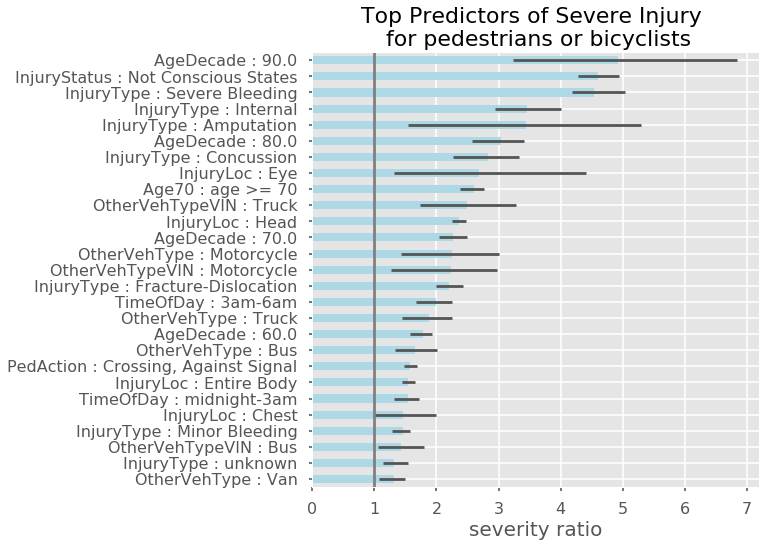

In [6]:
samples = bootstrapSR(ped,N=100)
plotSR(factorSev,samples)

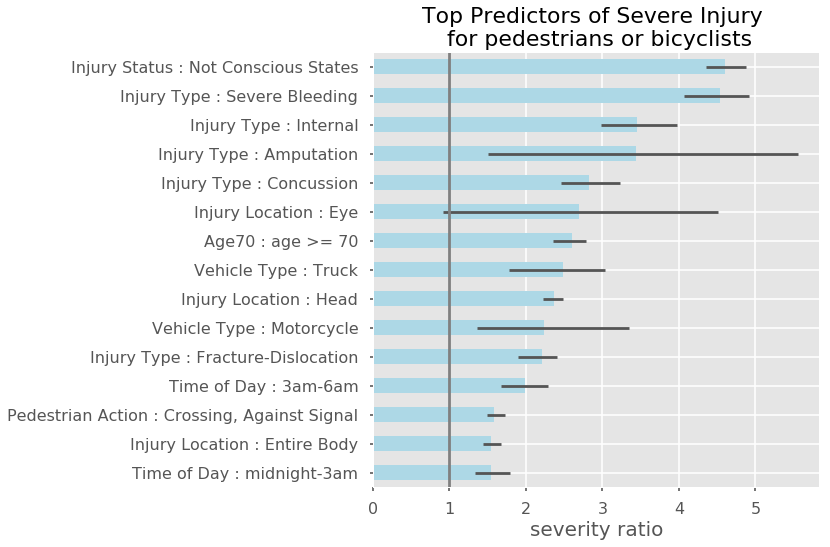

In [8]:
#clean up the graph, get rid of age by decades and the redundant VIN vehicle type

# drop age decades
ped_df = ped.drop(ped.filter(like='Decade').columns,axis=1)
# drop vehicle types coming from VIN (redundant)
ped_df = ped_df.drop('f_OtherVehType',axis=1)

factorSev = renameLabels(sratio(ped_df))
samples = renameLabels(bootstrapSR(ped_df,N=100))

plotSR(factorSev,samples,minSR=1.5)

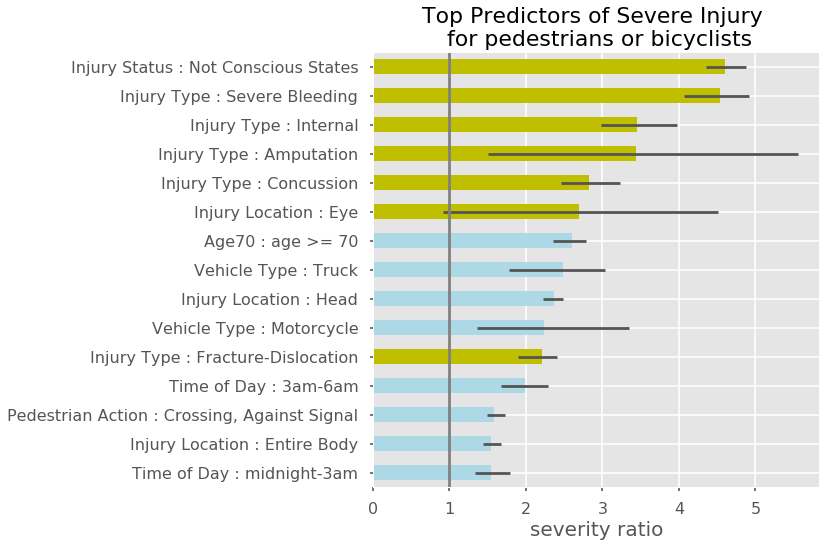

In [9]:
# redo graph with yellow bars for K,A injuries from KABCO
plotSR(factorSev,samples,minSR=1.5,
       colors=['lightblue']*4+['y']+['lightblue']*4+['y']*6)

Exclude elderly to see if there are any differences

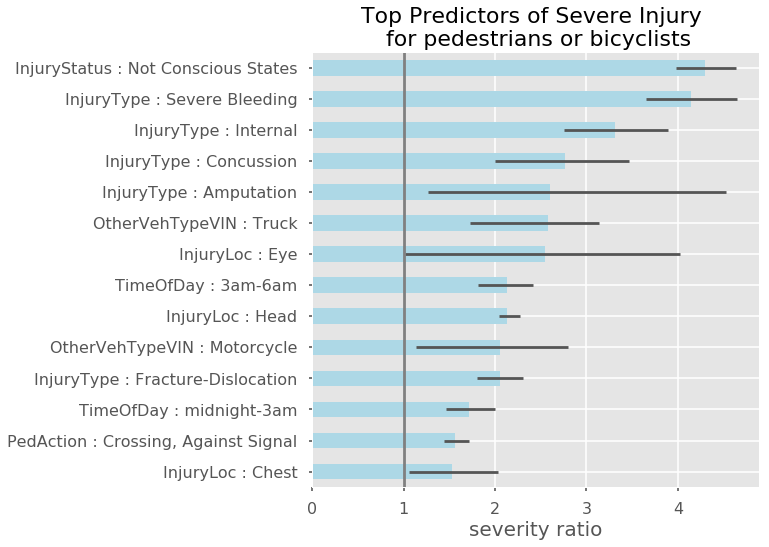

In [10]:
# Pedestrians under age 70
pedNotOld = ped_df[ped_df.f_AgeYear<70]
factorSevNotOld = sratio(pedNotOld)
samples = bootstrapSR(pedNotOld,N=100)
plotSR(factorSevNotOld,samples,minSR=1.5)

In [11]:
pedNotOld[pedNotOld.biss_severity_9=='severe'].shape

(1400, 103)

In [12]:
pedNotOld[pedNotOld.biss_severity_9=='severe'].shape[0]/float(pedNotOld.shape[0])

0.08536585365853659

## Section B. New KSI formulas
1. KABCO plus
1. Scoring Method

The previous section gives us a way of understanding which crash attributes are important. In this section we try to understand more quantitatively the impact of using one or more of those attributes in a formulat that labels crashes severe or not severe.

We use precission and recall metrics to measure how a new formula would perform compared to the existing KABCO formula created by DMV. 

### Metrics

**Precision**:  for crashes predicted ‘severe’ how many actually are? "Correctness" of labeled values

    True Positive / (True Positive + False Positive)
 
**Recall**: for crashes which are actually ‘severe’ how many are predicted correctly? "Capture rate"
    
    True Positive / (True Positive + False Negative)



###  1.  KABCO plus 

The "KABCO plus" formulas give a severe label to anything that is labeled K or A from KABCO plus one of the selected attributes: 
* person's age is 70+, 
* there is a head injury, 
* the other vehicle is a truck or motorcycle,
* any of the above. 


In [13]:
# dataframe that stores precision and recall information for the various models.
ksiplus = pd.DataFrame(columns=['FracCrashes','Precision','Recall',
                                'pLow','pHigh','rLow','rHigh'])

def addRow(data, N=100,frac=1):
    ''' returns a row to add to the the ksiplus dataframe
    data = injured person data 
    N = number of samples to use for bootstrapping
    frac = fraction of data to use for resampling
    
    '''
    #precision recall
    yPred = (data.newSev=='severe').astype(int)
    yActual = (data.biss_severity_9=='severe').astype(int)
    prec, recall = an.prec_recall(y_actual=yActual,y_predict=yPred, threshold=.5)
    fracCrashes = yPred.sum()/float(yPred.shape[0])
    
    # error bars
    precSample = []
    recSample = []
    for i in range(N):
        df = data.sample(frac=frac,replace=True)

        yPred = (df.newSev=='severe').astype(int)
        yActual = (df.biss_severity_9=='severe').astype(int)

        p,r = an.prec_recall(y_actual=yActual,y_predict=yPred,threshold=.5)

        precSample.append(p)
        recSample.append(r)

    pLow,pHigh = np.percentile(precSample,5),np.percentile(precSample,95)
    rLow,rHigh = np.percentile(recSample,5),np.percentile(recSample,95)

    row=[fracCrashes, prec, recall, pLow,pHigh,rLow,rHigh]
    return row

In [14]:
# baseline: K,A from KABCO
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'

ksiplus.loc['K,A']= addRow(ped,N=100)

# 70plus: age 70+
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_AgeYear>=70,'newSev'] = 'severe'

ksiplus.loc['K,A + age 70+']= addRow(ped,N=100)

# head: any head injury
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_InjuryLoc=='Head','newSev'] = 'severe'

ksiplus.loc['K,A + head injury']= addRow(ped,N=100)

# vehicle: vehicle = Truck, Motorcycle
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_OtherVehTypeVIN.isin(['Motorcycle','Truck']),'newSev'] = 'severe'

ksiplus.loc['K,A + motorcycle,truck']= addRow(ped,N=100)

# all: all of the above
ped['newSev'] = 'not severe'
ped.loc[ped.SEVERITY.isin(['K','A']),'newSev'] = 'severe'
ped.loc[ped.f_AgeYear>=70,'newSev'] = 'severe'
ped.loc[ped.f_InjuryLoc=='Head','newSev'] = 'severe'
ped.loc[ped.f_OtherVehTypeVIN.isin(['Motorcycle','Truck']),'newSev'] = 'severe'

ksiplus.loc['all above']= addRow(ped,N=100)


ksiplus


,FracCrashes,Precision,Recall,pLow,pHigh,rLow,rHigh
"K,A",0.137596,0.308866,0.438525,0.294881,0.325732,0.419282,0.456271
"K,A + age 70+",0.191954,0.268992,0.532787,0.258266,0.282939,0.513340,0.553746
"K,A + head injury",0.244269,0.229501,0.578454,0.218724,0.238674,0.559297,0.597402
"K,A + motorcycle,truck",0.146562,0.298103,0.450820,0.282765,0.317428,0.433561,0.471283
all above,0.295393,0.214176,0.652810,0.203765,0.222994,0.633323,0.675398


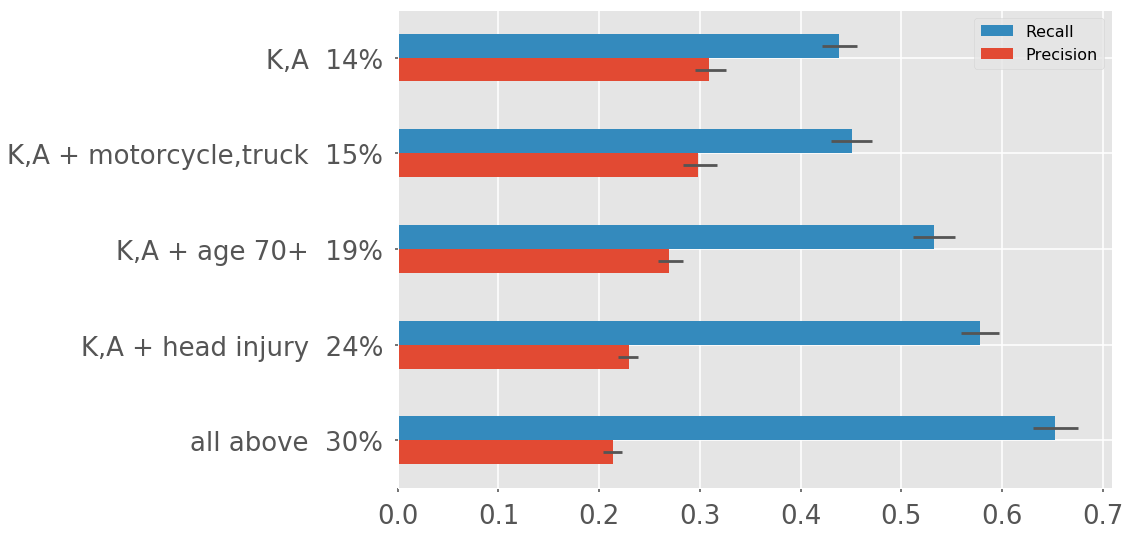

In [15]:
ksiplus.sort_values('Precision',inplace=True)
ksiplus.index = ksiplus.index +'  '\
    + (ksiplus.FracCrashes.astype(float)*100).round(0).astype(int).astype(str)+'%'

# error bars
ksiplus['pDeltaLow'] = ksiplus['Precision'] - ksiplus['pLow'] 
ksiplus['pDeltaHigh'] = ksiplus['pHigh'] - ksiplus['Precision']

ksiplus['rDeltaLow'] = ksiplus['Recall'] - ksiplus['rLow']
ksiplus['rDeltaHigh'] = ksiplus['rHigh'] - ksiplus['Recall']

perror = ksiplus[['pDeltaLow','pDeltaHigh']].T.values
rerror = ksiplus[['rDeltaHigh','rDeltaHigh']].T.values

error = [perror,rerror]

ksiplus[['Precision','Recall']].plot(kind='barh',xerr=error,fontsize=26,
                               legend='reverse')

With this method, you can increase the recall, so capturing more of the actually severe cases. But that sacrifices precision, meaning less of the labeled severe actually are. 

The next method is more flexible, allowing us to hold precision constant while increasing recall. The tradeoff is that it is more complicated to state which crashes are labeled severe.

### 2. Scoring Method 
 (using Logistic Regression models)
 
The rest of this notebook goes through the Scoring Method and how we come up with the attribute scores and threshold.

The general framework is:

* Assign a score to each crash attribute
* For each crash, add up total score based on which attributes are present
* Crashes with scores above a threshold are considered severe

Attribute scores are determined by fitting the data to a logistic regression model. 

The threshold determines where the output of the logit changes from not severe to severe. This threshold will be determined by choosing a point along the precision recall curve where the precision is equal to the baseline DMV/KABCO precision and the recall is optimized.

We use the optimal recall to determine which logistic regression model to use (the models are defined by the input variables (attributes) used). This process is called variable selection.

The function fitPlotMult() fits a logistic regression model to 80% of the data, chosen at random. It then uses the remaining 20% to calculate precision recall metrics at different thresholds. The result is plotted on a precision recall graph. The baseline DMV formula (KABCO) is also shown as a point on the graph. 

The first graph below shows the result for one run (N=1). This model only used the three injury variables as input to the model. You can see there is one point along the precision recall curve that intersects with the DMV/KABCO model. So there will be no improvent from the baseline DMV/KABCO formula.

Running this multiple times (N=10 below for example) leads to a distribution of optimal recall. It's randomly choosing a different 80% of the data to train on. We use the distribution to identify confidence intervals. 

The function fitPlotMult() returns a dataframe which gives the optimal recall and the associated precision and threshold for each run. Each row is a different run.

['f_InjuryType', 'f_InjuryStatus', 'f_InjuryLoc']
number of variables 28
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.271373
         Iterations 7
baseline dmv 
 precision   recall
0.31          0.44
optimal recall 0.5


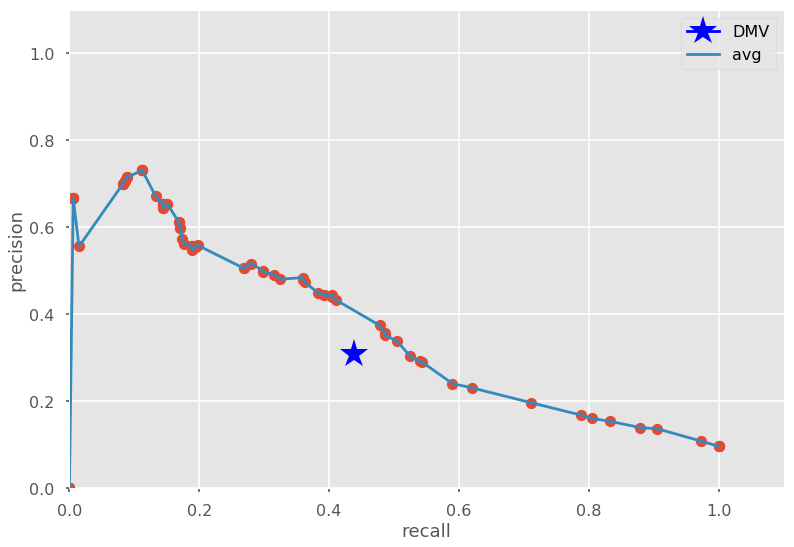

In [16]:
# only using the three injury variables
df = an.fitPlotMult(data=ped,pred=['f_InjuryType','f_InjuryStatus','f_InjuryLoc'],
                    N=1)

In [17]:
df

,index,precision,recall
0,0.15,0.338614,0.504425


['f_InjuryType', 'f_InjuryStatus', 'f_InjuryLoc']
number of variables 28
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.268571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268583
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.273265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269407
         Iterations 8
Optimization terminated success

/usr/local/lib/python2.7/dist-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python2.7/dist-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


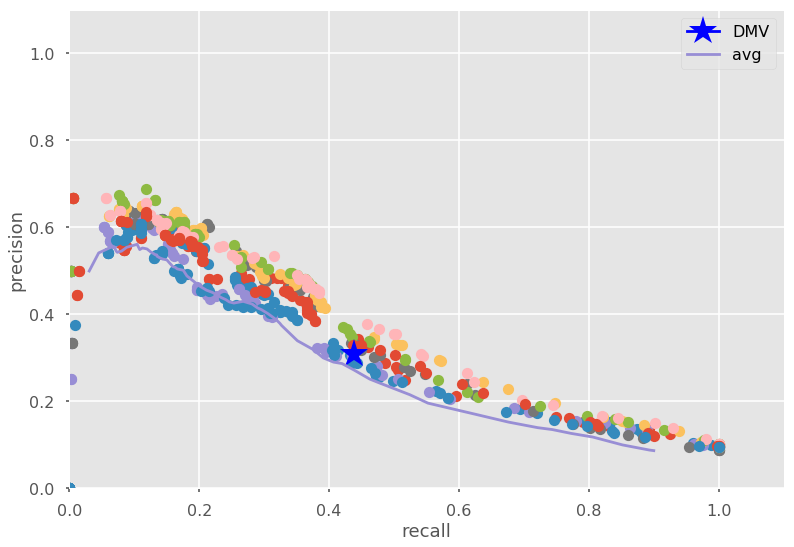

In [18]:
# same as above but 10 runs instead of 1 
df = an.fitPlotMult(data=ped,pred=['f_InjuryType','f_InjuryStatus','f_InjuryLoc'],
                    N=10)

In [19]:
df

,index,precision,recall
0,0.15,0.324435,0.459302
1,0.17,0.317241,0.414414
2,0.17,0.313679,0.395833
3,0.17,0.317972,0.449511
4,0.14,0.329435,0.512121
5,0.14,0.336735,0.463483
6,0.14,0.355159,0.502809
7,0.15,0.318271,0.477876
8,0.18,0.316397,0.407738


In [20]:
# listing [50%,5%,90%] values
an.median_recall(df)

('0.46', '0.40', '0.51')

By limiting the model to only using the three injury variables, we are not able to improve from the original DMV formula.

If we include ALL the variables we do see a 20-30% increase in the optimal recall compared to the baseline DMV recall.

['f_InjuryType', 'f_InjuryStatus', 'f_InjuryLoc', 'f_Sex', 'f_DriverSex', 'f_AgeDecade', 'f_DriverAgeDecade', 'f_Role', 'f_Eject', 'f_PedLoc', 'f_Lighting', 'f_TimeOfDay', 'f_RoadSurface', 'f_Weather', 'f_TrafficControl', 'f_PedAction', 'f_OtherVehAction', 'f_OtherVehType']
number of variables 93
number of data points 17624
number of severe instances 1708.0
test fraction 0.2
Optimization terminated successfully.
         Current function value: 0.255586
         Iterations 8
         Current function value: 0.252521
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.254160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.254588
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.249613
         Iterations 25
         Current function value: 0.250317
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.252194
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.251378
         Iterations 8
         Current function value: 0.250044
         Iterations: 35


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.254206
         Iterations 8
baseline dmv 
 precision   recall
0.31          0.44
optimal recall 0.55


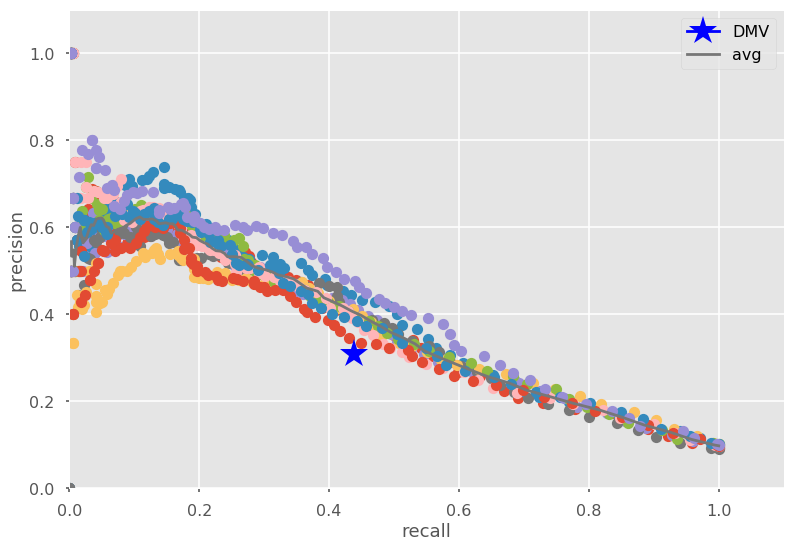

In [21]:
# include all the variables

var = list(ped.filter(like='f_').columns)
# remove redundant variables
remove = ['f_AgeYear','f_Age70','f_DriverAgeYear','f_DriverAge70',
         'f_OtherVehTypeVIN']
allvar = [x for x in var if x not in remove]

df = an.fitPlotMult(data=ped,pred=allvar,N=10)

In [22]:
an.median_recall(df)

('0.55', '0.52', '0.59')

#####  Variable Selection
We could use ALL the variables in our scoring formula, but it adds needless complexity. If more variables don't lead to better recall metric, we don't need them in the model.

In order to decide which variables (attributes) to use in the final formula, we will first limit the number of variables and then run through all possibilities. 

Keeping the three injury variables and then add in 2 more of the 15 other variables leads to 105 combinatins (15 choose 2 combinations). 

* Calculate the optimal recall for all variations. 
* Choose the model with the highest optimal recall. We're limiting it to 2 because otherwise the number of combinations becomes intractable. 

Note: Forward and backward selection was tried but did not work well. We re-evaluated and decided to do this 2 variable selection instead.

In [23]:
#baseline recall
y_actual = (ped.biss_severity_9=='severe').astype(int)
y_pred = (ped.SEVERITY.isin(['K','A'])).astype(int)
basePrec, baseRecall = an.prec_recall(y_actual=y_actual,y_predict=y_pred,threshold=.5)

print basePrec,baseRecall

0.3088659793814433 0.4385245901639344


Run all combinations of variable pairs. 
Add pairs to baseline injury variables. 
Capture precision and recall 

In [24]:
def varSelect(data,varOfInt,N=10):
    # set up dataframe to collect recall info for all the models
    models = pd.DataFrame(columns=['model','recall','recall low','recall high'])

    # include injury variables in all models
    inj=['f_InjuryType','f_InjuryLoc','f_InjuryStatus']

    # adding additional variable pairs and calculating recall
    for x in list(itertools.combinations(varOfInt,2)):
        pred = inj + [x[0],x[1]]
        op = an.fitPlotMult(data=data, pred=pred, N=N)
        models = models.append([{'model':'+'.join([x[0],x[1]]),
                                'recall':float(an.median_recall(op)[0]),
                                'recall low':float(an.median_recall(op)[1]),
                                'recall high': float(an.median_recall(op)[2]),
                                }],
                                ignore_index=True)
    models.index = models.model
    models.drop('model',axis=1,inplace=True)

    #clean up model names
    models.index = models.index.str.replace('f_','')#.str.replace('dec','')\
    #.str.replace('period','time').str.replace('road_','')

    # error bars for graphing will need the change in high and low values
    # not the values themselves
    models['delta low'] = models['recall low'] - models['recall']
    models['delta high'] = models['recall high'] - models['recall']
    
    return models

In [25]:
# list all variables, only remove injury variables and redundant age variables

var = list(ped.filter(like='f_').columns)
remove = ['f_InjuryType','f_InjuryLoc','f_InjuryStatus',
          'f_AgeYear','f_Age70','f_DriverAgeYear','f_DriverAge70','f_OtherVehType']

varOfInt = [x for x in var if x not in remove]
varOfInt

['f_Sex',
 'f_DriverSex',
 'f_AgeDecade',
 'f_DriverAgeDecade',
 'f_Role',
 'f_Eject',
 'f_PedLoc',
 'f_Lighting',
 'f_TimeOfDay',
 'f_RoadSurface',
 'f_Weather',
 'f_TrafficControl',
 'f_PedAction',
 'f_OtherVehAction',
 'f_OtherVehTypeVIN']

In [26]:
%%capture
models = varSelect(data=ped,varOfInt=varOfInt,N=100)

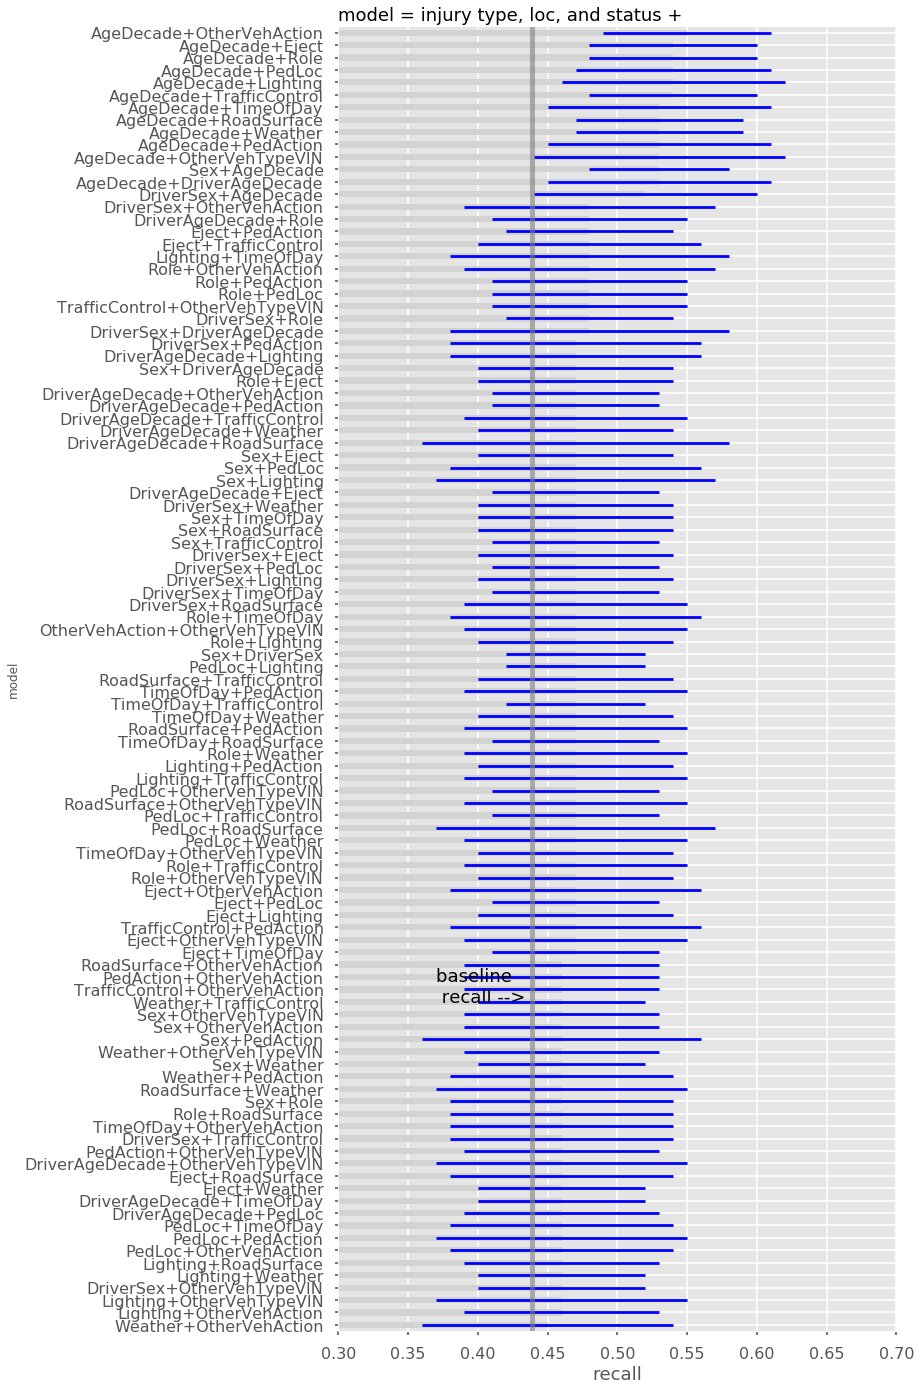

In [27]:
#plot
error = models[['delta low','delta high']].T.values
models[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,24),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,26,'baseline \n recall -->',fontsize=18)

All models where the optimal recall is clearly greater then the baseline (KABCO) recall are shown below. All of them have age as one of the variables in the model.

In [28]:
models[models['recall low']>baseRecall]

,recall,recall low,recall high,delta low,delta high
model,,,,,
Sex+AgeDecade,0.53,0.46,0.60,-0.07,0.07
DriverSex+AgeDecade,0.52,0.45,0.59,-0.07,0.07
AgeDecade+DriverAgeDecade,0.53,0.46,0.60,-0.07,0.07
AgeDecade+Role,0.54,0.47,0.60,-0.07,0.06
AgeDecade+Eject,0.54,0.47,0.58,-0.07,0.04
AgeDecade+PedLoc,0.54,0.48,0.59,-0.06,0.05
AgeDecade+Lighting,0.54,0.46,0.61,-0.08,0.07
AgeDecade+TimeOfDay,0.53,0.44,0.60,-0.09,0.07
AgeDecade+RoadSurface,0.53,0.46,0.59,-0.07,0.06


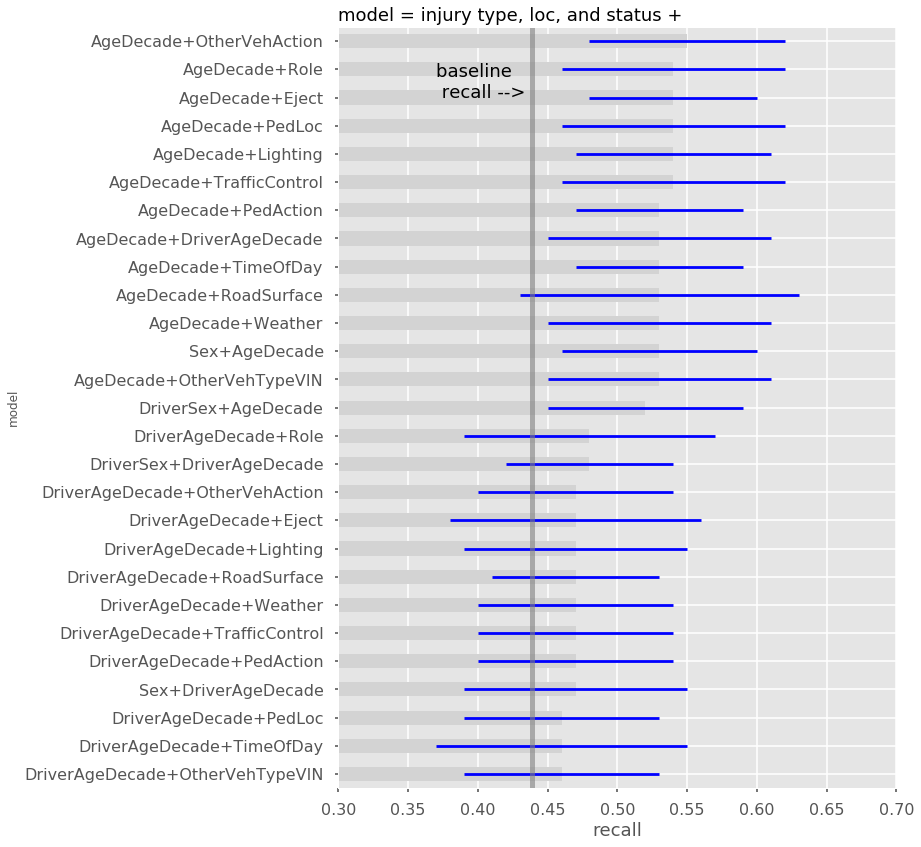

In [29]:
# look more closely at the age variables
md = models[models.index.str.contains('Age')].copy()

# error bars
md['delta low'] = md['recall low'] - md['recall']
md['delta high'] = md['recall high'] - md['recall']
error = md[['delta low','delta high']].T.values

md[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,14),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,24,'baseline \n recall -->',fontsize=18)

add in age by itself to bar graph

In [30]:
%%capture

# let's do only age by itself (with inj vars)

pred=['f_InjuryType','f_InjuryStatus','f_InjuryLoc','f_AgeDecade']

op = an.fitPlotMult(data=ped, pred=pred, N=100)

# add onto models2 dataframe
r = float(an.median_recall(op)[0])
rl = float(an.median_recall(op)[1])
rh = float(an.median_recall(op)[2])

models = models.append(pd.DataFrame(data=[{
                'recall':r,
                'recall low':rl,
                'recall high':rh,
                'delta low':rl-r,
                'delta high':rh-r
                }],index=['AgeDecade']))

limiting variables for easy graphing


In [31]:
models2 = models[models.index.str.contains('Age|VIN|Action')
                &(~models.index.str.contains('Sex|Role'))]

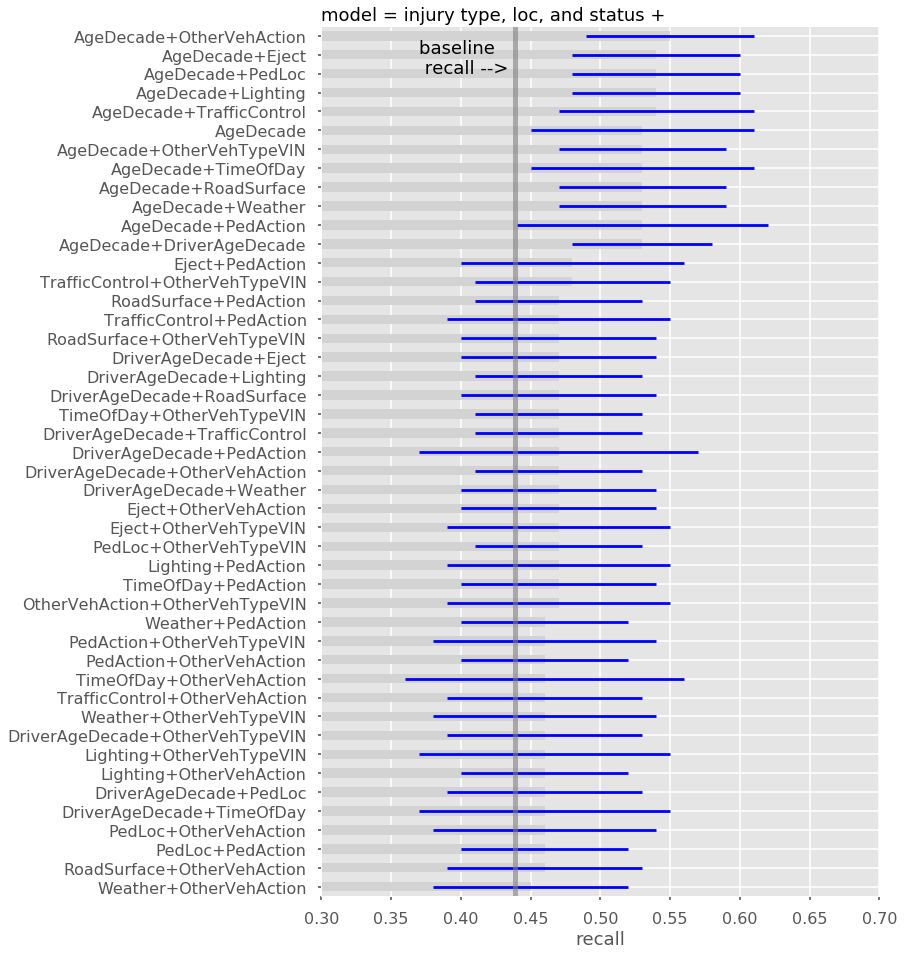

In [32]:
# error bars
error2 = models2[['delta low','delta high']].T.values

# plot
models2[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error2, figsize=(10,16),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,43,'baseline \n recall -->',fontsize=18)

In [33]:
# redo with age under 60

pedUnder60 = ped[ped.f_AgeYear<60]

print pedUnder60.shape
print pedUnder60[pedUnder60.biss_severity_9=='severe'].shape

(14974, 107)
(1154, 107)


In [34]:
%%capture
models = varSelect(data=pedUnder60,varOfInt=varOfInt,N=100)

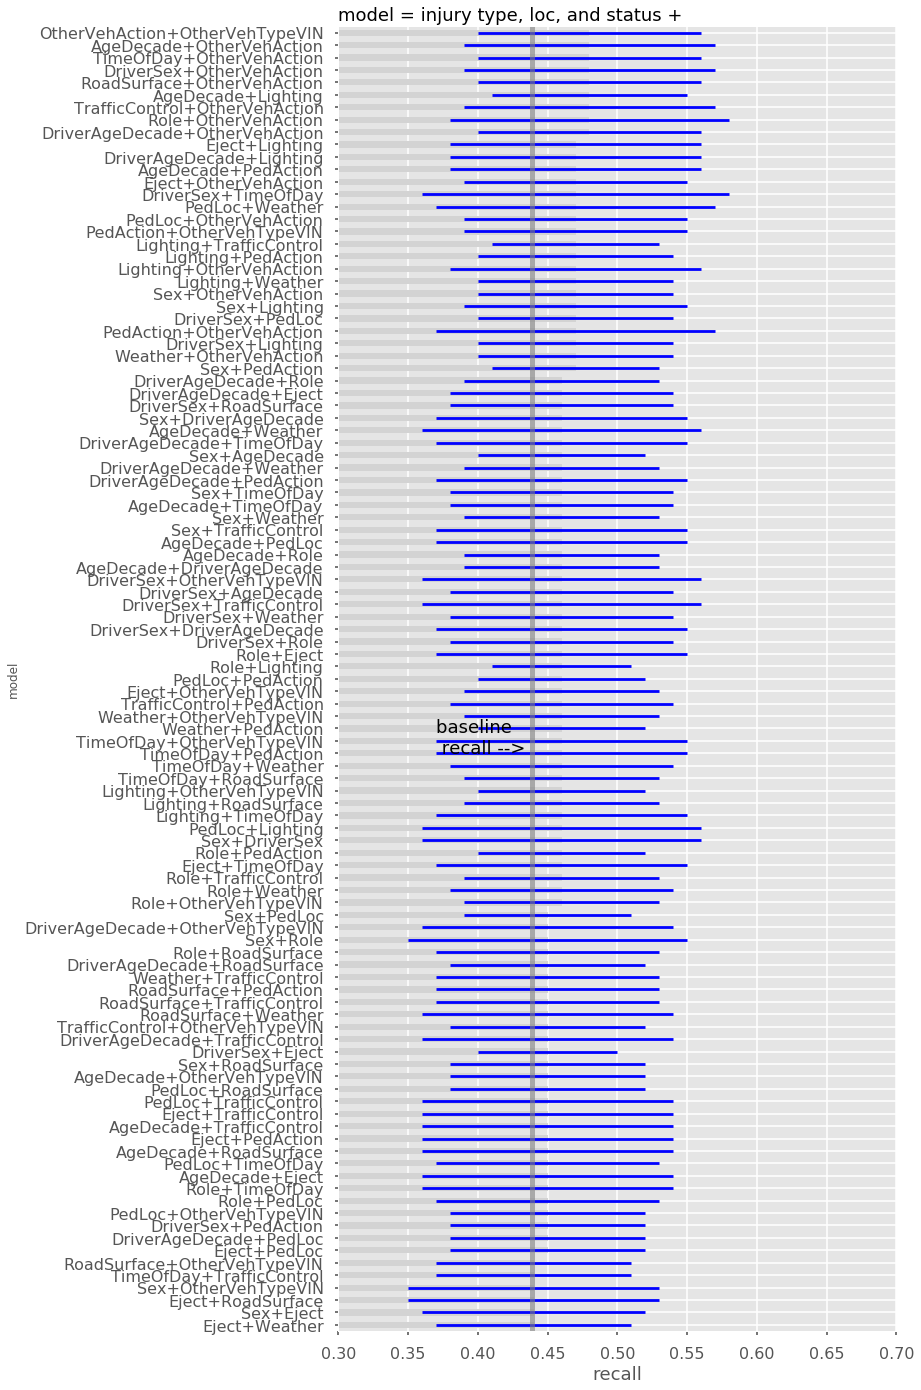

In [35]:
#plot
error = models[['delta low','delta high']].T.values
models[['recall']].sort_values('recall').plot(kind='barh',
                                              color='lightgrey',
                                              #edgecolor='black',
                                              ecolor='blue',
                                              xerr=error, figsize=(10,24),
                                              legend=False,xlim=(.3,.7))
plt.title('model = injury type, loc, and status +',fontsize=18,loc='left')
plt.xlabel('recall',fontsize=18)
plt.axvline(baseRecall, color ='grey', linewidth=5,alpha=.6)
plt.text(.37,46,'baseline \n recall -->',fontsize=18)

#### Logit Model Coefficients (scores)

The coefficients for the logistic regression model are calculated using the full dataset (i.e. not splitting into training testing) and the variables decided on based on the recall improvement from the last section. 


Model with the following input variables:
* injury type
* injury status
* injury location
* age
* vehicle type

Optimization terminated successfully.
         Current function value: 0.259716
         Iterations 8


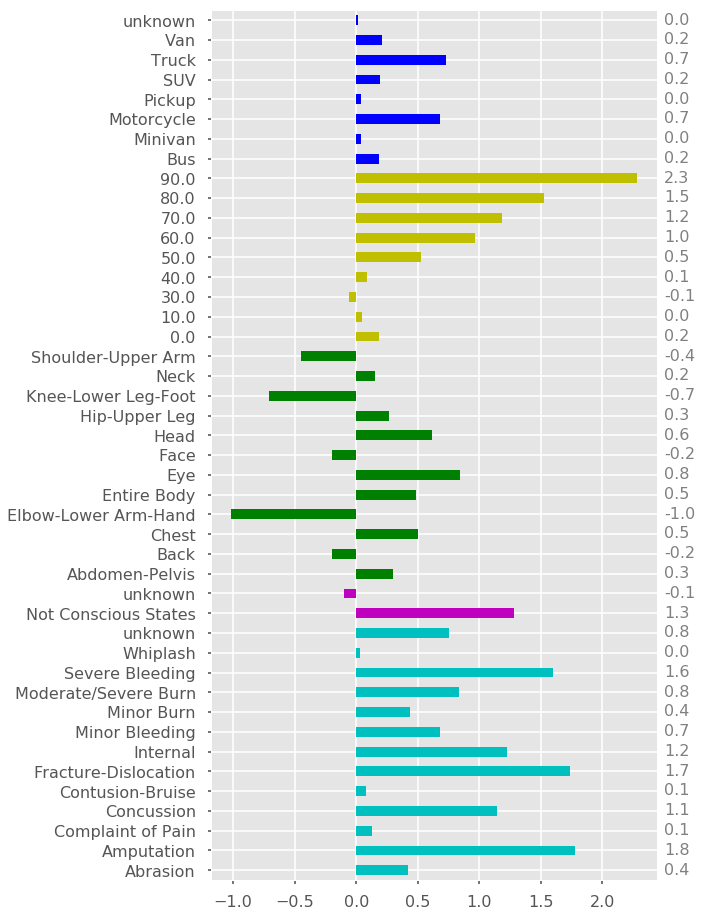

In [39]:
# set up X and y
pred = ["C(f_InjuryType,Treatment(reference='None Visible'))", 
        "C(f_InjuryStatus,Treatment(reference='Conscious states'))", 
        "C(f_InjuryLoc,Treatment(reference='unknown'))",
        "C(f_AgeDecade,Treatment(reference='20.0'))",
        "C(f_OtherVehTypeVIN,Treatment(reference='Car'))",
#        "C(f_OtherVehicleAction,Treatment(reference='unknown'))",

       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

# print out coefficient values (rounded off)
coeff = model.params[1:].tolist()
coeff = [round(x,1) for x in coeff]

for i, v in enumerate(coeff):
    plt.text(2.5 , i - .2 , str(v),fontsize=16,color='grey')

From the precision recall curve, the optimal recall happens at threshold p_th = 0.13. 

\begin{equation}
\log{\frac{p_{th}}{1-p_{th}}} = b_0 + sum of scores_{th}
\end{equation}

This means that all crashes with total score greater than 1.4 are considered severe.

In [40]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.3632211398988932

This model is similar to above but with vehicle action instead of vehicle type.

Model with the following input variables:
* injury type
* injury status
* injury location
* age
* vehicle pre-crash action

Optimization terminated successfully.
         Current function value: 0.257778
         Iterations 8


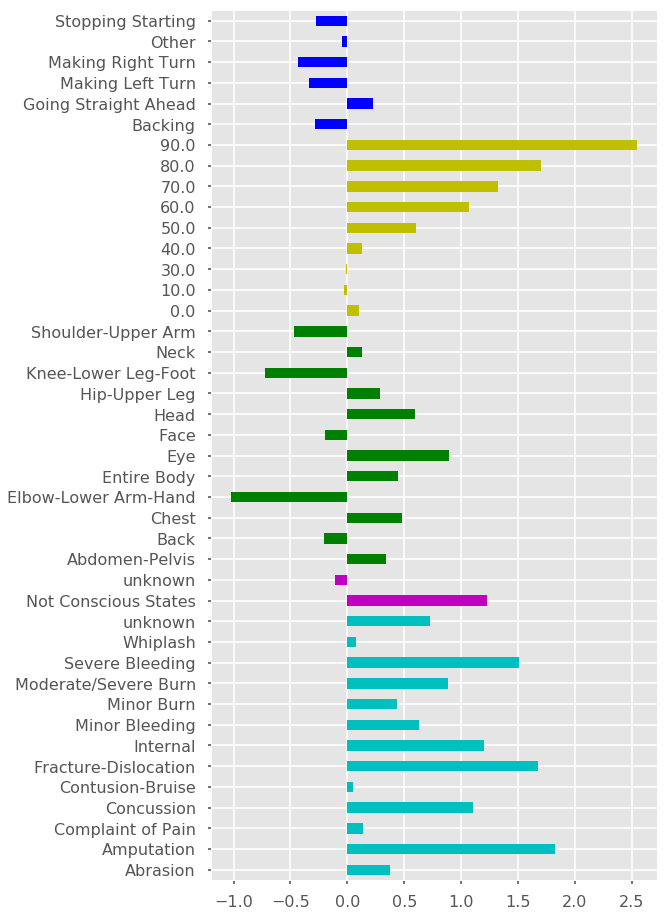

In [42]:
# set up X and y
pred = ["C(f_InjuryType,Treatment(reference='None Visible'))", 
        "C(f_InjuryStatus,Treatment(reference='Conscious states'))", 
        "C(f_InjuryLoc,Treatment(reference='unknown'))",
        "C(f_AgeDecade,Treatment(reference='20.0'))",
#        "C(f_OtherVehTypeVIN,Treatment(reference='Car'))",
        "C(f_OtherVehAction,Treatment(reference='unknown'))",
       ]
        
y,X = dmatrices('biss_severity_9' + '~' + '+'.join(pred),
                    ped, return_type='dataframe')
y = np.ravel(y['biss_severity_9[severe]'])

X.columns = X.columns.str[2:].str.split('\)\)\[T.').str.get(1).str[:-1]

# fit model
model = sm.Logit(y,X).fit()

# plot coefficients
colors = ['c']*13+['m']*2+['g']*12 + ['y']*9 + ['b']*10
model.params[1:].plot(kind='barh',figsize=(8,16),color=colors)

In [44]:
threshold = .13
Intercept = model.params[0]

np.log(threshold/(1-threshold)) - Intercept

1.270381081177864

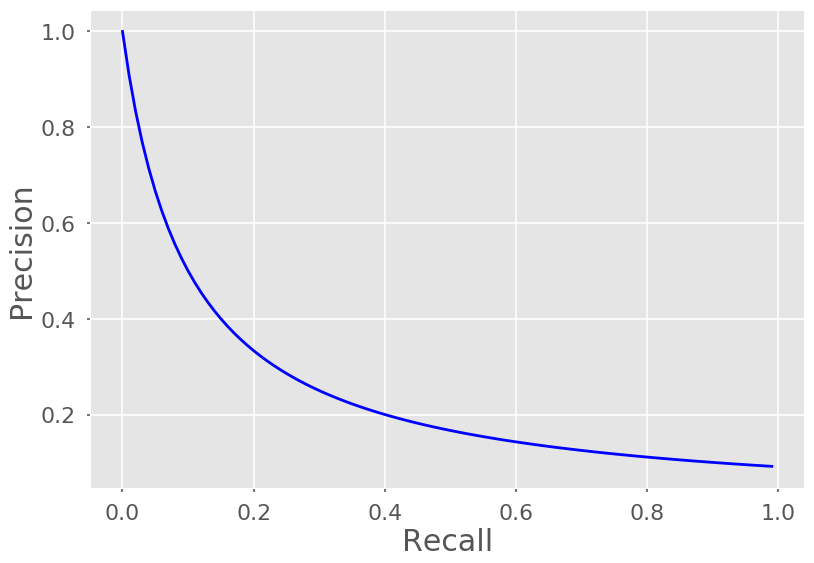

In [43]:
# fake precision - recall curve for presentation slides

t = np.arange(0.0, 1.0, 0.01)
plt.plot(t, .001/(.01*t+.001),'blue')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Recall',fontsize=30)
plt.ylabel('Precision',fontsize=30)